In [1]:
import modelo as m
import pandas as pd
import Bio.KEGG.REST as rkg
import Bio.KEGG.Enzyme as ex
import networkx as nx
import cufflinks as cf
import pylab as pl
import numpy as np
import plotly.tools as tls
import powerlaw
from plotly.graph_objs import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from plotly.offline import *
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import random

random.seed(42)

init_notebook_mode(connected=True)

In [2]:
def roc(cv, X, y, mean_fpr, aucs,tprs,classifier):
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return (plt)

## Reading datasets

In [3]:
data_d_all = pd.read_csv("data/dall.csv") #Digraph with all nodes
data_d_wi = pd.read_csv("data/dwi.csv") #Digraph without isolate nodes
data_g_all = pd.read_csv("data/gall.csv") #Graph with all nodes
data_g_wi = pd.read_csv("data/gwi.csv") #Graph without all nodes

## Drop unused column

In [4]:
data_d_all = data_d_all.drop(["Unnamed: 0", "ec"], axis=1)
data_d_wi = data_d_wi.drop(["Unnamed: 0", "ec"], axis=1)
data_g_all = data_g_all.drop(["Unnamed: 0", "ec"], axis=1)
data_g_wi = data_g_wi.drop(["Unnamed: 0", "ec"], axis=1)

## Machine Learning Tests

### SVM: (RBF)

In [5]:
random_state = np.random.RandomState(0) 
cv = StratifiedKFold(n_splits=4)
classifier = SVC(kernel='rbf', probability=True,
                     random_state=random_state)

## Splitting datasets in train and test

In [6]:
X_dall,y_dall = data_d_all.iloc[:,:-1],data_d_all.iloc[:,-1]
for i in range(y_dall.shape[0]):
    if y_dall[i] == 1:
        y_dall.at[i] = 0
    elif y_dall[i] == 0 or y_dall[i]==2:
        y_dall.at[i] = 1
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)

X_dwi,y_dwi = data_d_wi.iloc[:,:-1],data_d_wi.iloc[:,-1]
for i in range(y_dwi.shape[0]):
    if y_dwi[i] == 1:
        y_dwi.at[i] = 0
    elif y_dwi[i] == 0 or y_dwi[i]==2:
        y_dwi.at[i] = 1
tprs_dwi = []
aucs_dwi = []
mean_fpr_dwi = np.linspace(0, 1, 100)

X_gall,y_gall = data_g_all.iloc[:,:-1],data_g_all.iloc[:,-1]
for i in range(y_gall.shape[0]):
    if y_gall[i] == 1:
        y_gall.at[i] = 0
    elif y_gall[i] == 0 or y_gall[i]==2:
        y_gall.at[i] = 1
tprs_gall = []
aucs_gall = []
mean_fpr_gall = np.linspace(0, 1, 100)

X_gwi,y_gwi = data_g_wi.iloc[:,:-1],data_g_wi.iloc[:,-1]
for i in range(y_gwi.shape[0]):
    if y_gwi[i] == 1:
        y_gwi.at[i] = 0
    elif y_gwi[i] == 0 or y_gwi[i]==2:
        y_gwi.at[i] = 1
tprs_gwi = []
aucs_gwi = []
mean_fpr_gwi = np.linspace(0, 1, 100)

Text(0.5,1,'Graph Without Isolates')

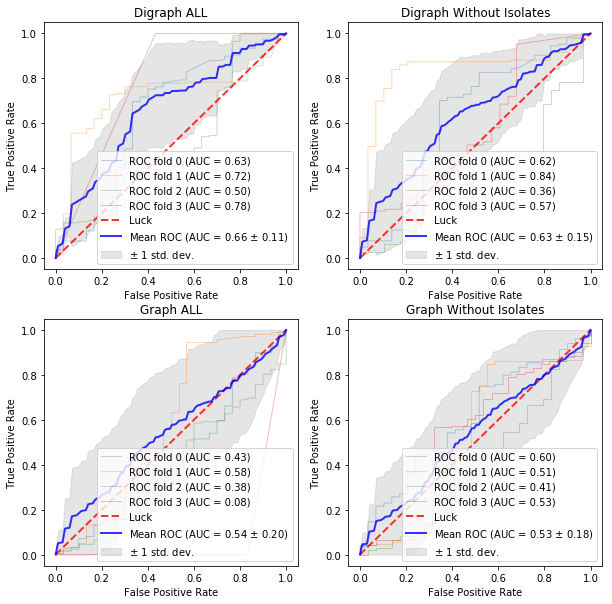

In [7]:
row=2
col=2
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(row, col, 1)
imgplot1 = roc(cv, X_dall, y_dall, mean_fpr_dall, aucs_dall,tprs_dall,classifier)
a.set_title('Digraph ALL')
a = fig.add_subplot(row, col, 2)
imgplot2 = roc(cv, X_dwi, y_dwi, mean_fpr_dall, aucs_dall,tprs_dall,classifier)
a.set_title('Digraph Without Isolates')
a = fig.add_subplot(row, col, 3)
imgplot3 = roc(cv, X_gall, y_gall, mean_fpr_dall, aucs_dall,tprs_dall,classifier)
a.set_title('Graph ALL')
a = fig.add_subplot(row, col, 4)
imgplot4 = roc(cv, X_gwi, y_gwi, mean_fpr_dall, aucs_dall,tprs_dall,classifier)
a.set_title('Graph Without Isolates')

### Random Forest: Entropy

Text(0.5,1,'Graph Without Isolates')

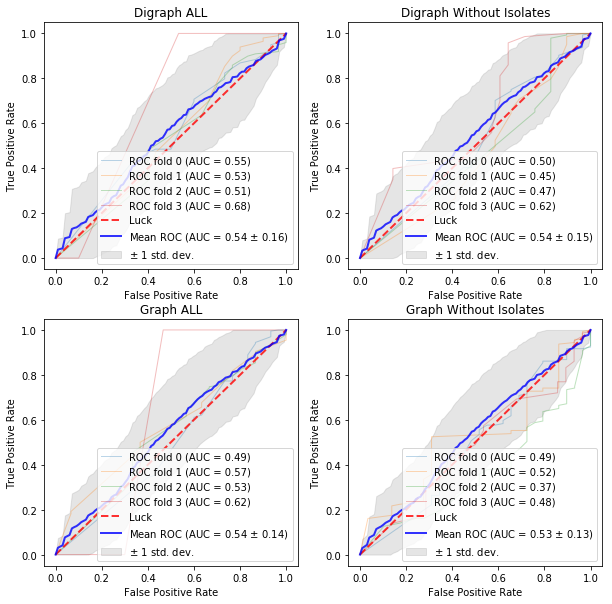

In [8]:
clf = RFC(criterion='entropy')
row=2
col=2
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(row, col, 1)
imgplot1 = roc(cv, X_dall, y_dall, mean_fpr_dall, aucs_dall,tprs_dall,clf)
a.set_title('Digraph ALL')
a = fig.add_subplot(row, col, 2)
imgplot2 = roc(cv, X_dwi, y_dwi, mean_fpr_dall, aucs_dall,tprs_dall,clf)
a.set_title('Digraph Without Isolates')
a = fig.add_subplot(row, col, 3)
imgplot3 = roc(cv, X_gall, y_gall, mean_fpr_dall, aucs_dall,tprs_dall,clf)
a.set_title('Graph ALL')
a = fig.add_subplot(row, col, 4)
imgplot4 = roc(cv, X_gwi, y_gwi, mean_fpr_dall, aucs_dall,tprs_dall,clf)
a.set_title('Graph Without Isolates')

Text(0.5,1,'Graph Without Isolates')

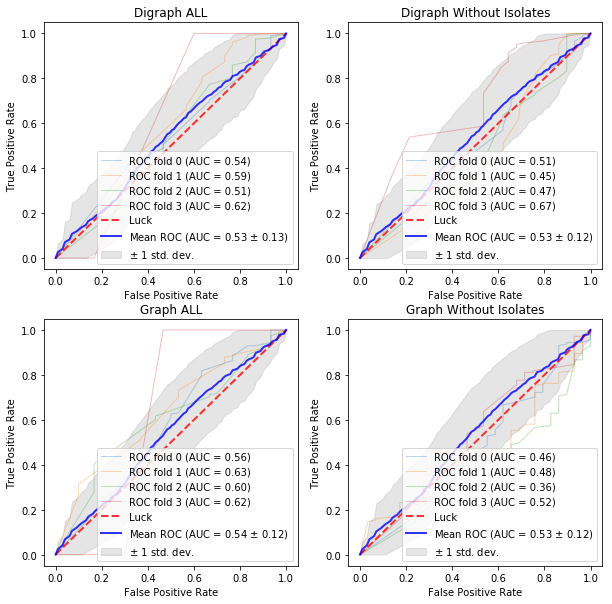

In [9]:
clf = RFC(criterion='gini')
row=2
col=2
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(row, col, 1)
imgplot1 = roc(cv, X_dall, y_dall, mean_fpr_dall, aucs_dall,tprs_dall,clf)
a.set_title('Digraph ALL')
a = fig.add_subplot(row, col, 2)
imgplot2 = roc(cv, X_dwi, y_dwi, mean_fpr_dall, aucs_dall,tprs_dall,clf)
a.set_title('Digraph Without Isolates')
a = fig.add_subplot(row, col, 3)
imgplot3 = roc(cv, X_gall, y_gall, mean_fpr_dall, aucs_dall,tprs_dall,clf)
a.set_title('Graph ALL')
a = fig.add_subplot(row, col, 4)
imgplot4 = roc(cv, X_gwi, y_gwi, mean_fpr_dall, aucs_dall,tprs_dall,clf)
a.set_title('Graph Without Isolates')